In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Input,
    Embedding,
    Dot,
    Dense,
    Flatten,
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
    EarlyStopping,
)

from wordcloud import WordCloud

%matplotlib inline

### Load animelist.csv data 

In [ ]:
import os

# Define the path to the input directory containing raw data files
INPUT_DIR = os.path.join("..", "artifacts", "raw")

# Read the animelist.csv file using only the relevant columns
# We're using low_memory=True for performance and only loading 'user_id', 'anime_id', and 'rating'
rating_df = pd.read_csv(
    os.path.join(INPUT_DIR, "animelist.csv"),
    low_memory=True,
    usecols=["user_id", "anime_id", "rating"],
)

# Show the first few rows of the DataFrame
rating_df.head()


,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
# length
len(rating_df)

5000000

### Data Processing

In [ ]:
# Count how many ratings each user has given
n_ratings = rating_df["user_id"].value_counts()

# Keep only those users who have rated at least 400 anime
# This helps reduce data sparsity and focuses on active users
rating_df = rating_df[
    rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)
].copy()

In [9]:
print(f"Filtered active users count: {rating_df['user_id'].nunique()}")
print(f"Total ratings after filtering: {rating_df.shape[0]}")

Filtered active users count: 4203
Total ratings after filtering: 3246641


In [10]:
# Get the minimum rating given by any user
min_rating = min(rating_df["rating"])

# Get the maximum rating given by any user
max_rating = max(rating_df["rating"])

# Calculate the average (mean) rating across all users and anime
avg_rating = np.mean(rating_df["rating"])

In [11]:
print(f"Min Rating : {min_rating}")
print(f"Max Rating : {max_rating}")
print(f"Avg Rating : {avg_rating:.2f}")

Min Rating : 0
Max Rating : 10
Avg Rating : 4.12


#### Normalize Ratings to [0, 1]

In [ ]:
# apply Min-Max Normalization to scale ratings between 0 and 1
rating_df["rating"] = (
    rating_df["rating"]
    .apply(lambda x: (x - min_rating) / (max_rating - min_rating))
    .values.astype(np.float64)
)

In [13]:
# Check the scaled values
print("After normalization:")
print(f"Min  → {rating_df['rating'].min()}")
print(f"Max  → {rating_df['rating'].max()}")
print(f"Mean → {rating_df['rating'].mean():.4f}")

After normalization:
Min  → 0.0
Max  → 1.0
Mean → 0.4123


#### Check Duplicates

In [14]:
rating_df.duplicated().sum()

np.int64(0)

#### Check Missing Values

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

#### Encoding user_id and anime_id
- To train a neural recommendation model, we need to convert categorical IDs (user_id and anime_id) into integer indices. This is essential because embedding layers in deep learning models expect input values ranging from 0 to N-1 (where N is the number of unique users or items).

  + user_id → user: Encoded user index
  + anime_id → anime: Encoded anime index

- These encoded values allow us to use efficient embedding layers and ensure stable model training.

| Original `anime_id` | Encoded `anime` (Index) |
| ------------------- | ----------------------- |
| 21                  | 0                       |
| 3125                | 1                       |
| 67                  | 2                       |
| 2104                | 3                       |
| 4898                | 4                       |
| ...                 | ...                     |


#### Encode user_id to Integer for Embedding Layer

In [ ]:
# -----------------------------------------------
# Step: Encode `user_id` to Integer Indices
# -----------------------------------------------

# Extract unique user IDs and convert them to a list
user_ids = rating_df["user_id"].unique().tolist()

# Create a mapping from original user_id → encoded ID
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

# Also store the reverse mapping (encoded ID → original user_id)
user2user_decoded = {i: x for i, x in enumerate(user_ids)}

# Apply the encoding to the dataframe to create a new 'user' column
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [29]:
n_users = len(user2user_encoded)
print(f"Number of unique users: {n_users}")
print(rating_df[["user_id", "user"]].head())

Number of unique users: 4203
   user_id  user
0      457   120
1     4903  1195
2     6313  1591
3    15851  4024
4     1596   415


#### Encode anime_id to Integer for Embedding Layer

In [18]:
# -----------------------------------------------
# Encode `anime_id` to Integer Indices
# -----------------------------------------------

# Get a list of all unique anime IDs
anime_ids = rating_df["anime_id"].unique().tolist()

# Create a mapping from original anime_id → encoded ID (0 to N-1)
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}

# Create a reverse mapping (encoded ID → original anime_id)
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}

# Apply the encoding to the dataframe to create a new 'anime' column
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [30]:
n_anime = len(anime2anime_encoded)
print(f"Unique animes encoded: {n_anime}")
print(rating_df[["anime_id", "anime"]].head())

Unique animes encoded: 17149
   anime_id  anime
0     18153   1377
1     20507   1216
2     23325   1239
3     37491   1813
4     29803    353


#### Shuffle the Dataset

In [20]:
# Shuffle the entire DataFrame to remove any ordering bias
# frac=1 means 100% of data is used, random_state ensures reproducibility
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [21]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


#### Create Feature Matrix X and Target Vector y

In [22]:
# X contains pairs of encoded user and anime IDs
X = rating_df[["user", "anime"]].values

# y contains the corresponding normalized ratings
y = rating_df["rating"]

#### Train–Test Split (Last 1000 for Testing)

In [23]:
# ------------------------------------------------------
# Train-Test Split with Fixed Test Size = 1000
# ------------------------------------------------------

# Set aside the last 1000 samples for testing
test_size = 1000

# Calculate how many samples go into training
train_indices = rating_df.shape[0] - test_size

# Manual split into training and test sets
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [24]:
print("X_train:\n", X_train[:5])
print("\nX_test:\n", X_test[:5])

print("\ny_train:\n", y_train[:5].values)
print("\ny_test:\n", y_test[:5].values)

X_train:
 [[ 120 1377]
 [1195 1216]
 [1591 1239]
 [4024 1813]
 [ 415  353]]

X_test:
 [[  266  1513]
 [ 2572  1623]
 [ 2555 12942]
 [  658  1068]
 [   88  4390]]

y_train:
 [0.9 0.7 0.  0.  0.9]

y_test:
 [0.  0.  0.2 1.  0.9]


In [25]:
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))

print("Length of X_test:", len(X_test))
print("Length of y_test:", len(y_test))

Length of X_train: 3245641
Length of y_train: 3245641
Length of X_test: 1000
Length of y_test: 1000


#### Prepare Model Inputs for Training

In [27]:
# ---------------------------------------------------
# Split Feature Matrix into Separate Inputs
# ---------------------------------------------------

# X_train[:, 0] → user indices
# X_train[:, 1] → anime indices

# Keras expects inputs to be fed separately for each embedding
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [28]:
print(len(X_train_array))  # 2 → [user_input, anime_input]
print(X_train_array[0].shape)  # (N_train,)
print(X_train_array[1].shape)  # (N_train,)

2
(3245641,)
(3245641,)


### Define the Recommender Model – RecommenderNet

In [31]:
# ----------------------------------------
# Define the Neural Collaborative Filtering Model
# ----------------------------------------


def RecommenderNet():
    embedding_size = 128  # 🔧 Number of latent factors for each user/anime
    # 🧍 User input
    user = Input(name="user", shape=[1])
    user_embedding = Embedding(
        input_dim=n_users,  # total unique users
        output_dim=embedding_size,  # embedding size
        name="user_embedding",
    )(user)

    # 📺 Anime input
    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(
        input_dim=n_anime,  # total unique animes
        output_dim=embedding_size,  # embedding size
        name="anime_embedding",
    )(anime)

    # 🔗 Combine embeddings with normalized dot product(check similary)
    x = Dot(axes=2, normalize=True, name="dot_product")(
        [user_embedding, anime_embedding]
    )

    # 📤 Output prediction layer
    x = Flatten()(x)
    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)  # normalized rating output between 0 and 1

    # 🔧 Compile the model
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(
        loss="binary_crossentropy",  # suitable for sigmoid + normalized rating
        optimizer=Adam(),
        metrics=["mae", "mse"],
    )

    return model


In [32]:
model = RecommenderNet()

In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

### Define Custom Learning Rate Schedule

In [ ]:
# --------------------------------------------------------
# - Define Learning Rate Function for Training Schedule
# - Gradually increase LR for 'ramup_epochs'
# - Optionally hold (sustain) for few epochs
# - Then exponentially decay LR
# --------------------------------------------------------

start_lr = 1e-5  # Initial learning rate (very small)
min_lr = 1e-4  # Minimum learning rate after decay
max_lr = 5e-5  # Peak learning rate after ramp-up
batch_size = 10000  # For info/logging (not directly used here)

ramup_epochs = 5  # Number of warm-up epochs
sustain_epochs = 0  # Number of sustain (flat peak) epochs
exp_decay = 0.8  # Exponential decay factor after peak


def lrfn(epoch):
    if epoch < ramup_epochs:
        # 📈 Linear ramp-up
        return (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        # ➖ Sustain max_lr
        return max_lr
    else:
        # 📉 Exponential decay
        return (max_lr - min_lr) * exp_decay ** (
            epoch - ramup_epochs - sustain_epochs
        ) + min_lr

### Define Training Callbacks

In [ ]:
# Learning Rate Scheduler using lrfn
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# Model Checkpoint: Save best weights during training
checkpoint_filepath = "./weights.weights.h5"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",  # Watch validation loss
    mode="min",  # Save when val_loss is at minimum
    save_best_only=True,  # Only save the best weights
)

# Early Stopping: Stop training early if no improvement
early_stopping = EarlyStopping(
    patience=3,  # Stop after 3 epochs with no improvement
    monitor="val_loss",  # Monitor validation loss
    mode="min",
    restore_best_weights=True,
)

#### Combine All Training Callbacks

In [ ]:
# Combine all callbacks into a list for training
my_callbacks = [
    model_checkpoint,  # Save best weights
    lr_callback,  # Custom learning rate schedule
    early_stopping,  # Stop early if no val_loss improvement
]

#### Model Training: Fit Recommender System

In [ ]:
history = model.fit(
    x=X_train_array,  # 🧍‍♂️👾 User-Anime input pairs
    y=y_train,  # 🎯 Normalized ratings
    batch_size=batch_size,  # 🔄 Number of samples per gradient update
    epochs=20,  # 🕒 Max training epochs
    verbose=1,  # 📢 Show progress
    validation_data=(X_test_array, y_test),  # 🧪 Evaluate on test set
    callbacks=my_callbacks,  # ⏹️ EarlyStopping + 📉 LR Scheduler + 💾 ModelCheckpoint
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 133s 370ms/step - loss: 0.6941 - mae: 0.3611 - mse: 0.1560 - val_loss: 0.6927 - val_mae: 0.3607 - val_mse: 0.1555 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 158s 418ms/step - loss: 0.6934 - mae: 0.3609 - mse: 0.1556 - val_loss: 0.6920 - val_mae: 0.3607 - val_mse: 0.1552 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 134s 390ms/step - loss: 0.6924 - mae: 0.3607 - mse: 0.1551 - val_loss: 0.6909 - val_mae: 0.3607 - val_mse: 0.1546 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 160s 435ms/step - loss: 0.6912 - mae: 0.3607 - mse: 0.1546 - val_loss: 0.6900 - val_mae: 0.3608 - val_mse: 0.1542 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 117s 354ms/step - loss: 0.6900 - mae: 0.3605 - mse: 0.1539 - val_loss: 0.6891 - val_mae: 0.3607 - val_mse: 0.1537 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 141s 348ms/step - loss: 0.6882 - mae: 0.3600 - mse

#### Visualize Training & Validation Metrics

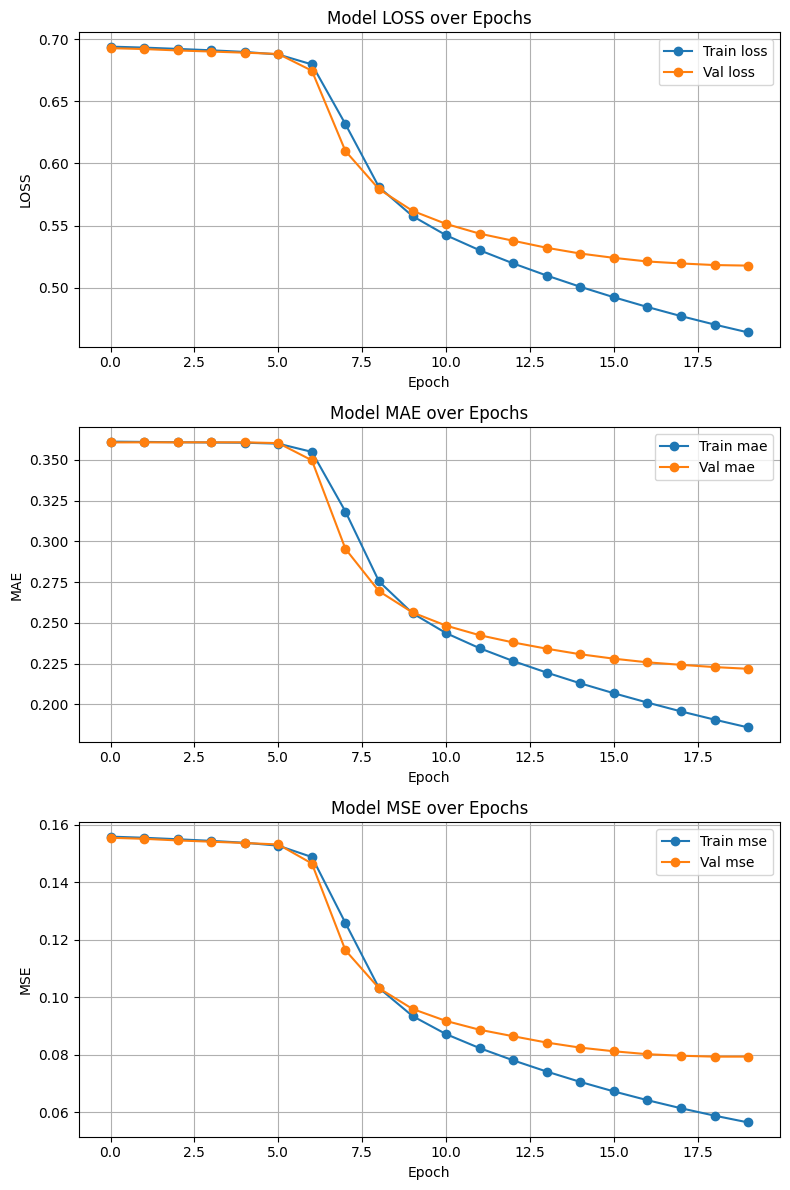

In [38]:
# Metrics to track
metrics = ["loss", "mae", "mse"]

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot training metric
    ax.plot(history.history[metric], marker="o", label=f"Train {metric}")

    # Plot validation metric
    ax.plot(history.history[f"val_{metric}"], marker="o", label=f"Val {metric}")

    ax.set_title(f"Model {metric.upper()} over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.upper())
    ax.legend(loc="upper right")
    ax.grid(True)

plt.tight_layout()
plt.show()


####  Extract and Normalize Embedding Weights

In [39]:
def extract_weights(name, model):
    """
    Extracts and normalizes embedding weights from the specified layer in a Keras model.

    Parameters:
        name (str): Name of the embedding layer (e.g., "user_embedding", "anime_embedding").
        model (Model): Trained Keras model.

    Returns:
        np.ndarray: L2-normalized embedding weights (shape: [num_items, embedding_dim]).
    """
    #  Get embedding layer by name
    weight_layer = model.get_layer(name)

    # Get the weight matrix
    weights = weight_layer.get_weights()[0]  # shape: (num_users/animes, embedding_dim)

    # Normalize each embedding vector (L2 norm = 1)
    weights = weights / np.linalg.norm(weights, axis=1, keepdims=True)

    return weights

In [ ]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

### Load Anime Metadata (anime.csv) 

In [42]:
# Load the anime metadata file
df = pd.read_csv(INPUT_DIR + "/anime.csv", low_memory=True)

# Display the first few rows
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [43]:
# # Replace all "Unknown" strings with proper NaN values
df = df.replace("Unknown", np.nan)

####  Helper Function: Get Anime Name by anime_id

In [47]:
# Make sure correct column references exist
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]

In [ ]:
# Define the helper function properly
def getAnimeName(anime_id):
    """
    Fetch the English name of an anime using its anime_id.
    Falls back to Japanese name if English name is not available.

    Parameters:
        anime_id (int): Unique ID of the anime

    Returns:
        str: Anime name (English or fallback)
    """
    try:
        row = df[df["anime_id"] == anime_id]
        if not row.empty:
            name = row["eng_version"].values[0]
            if pd.isna(name):
                name = row["Name"].values[0]
            return name
        else:
            return "Anime ID not found"
    except Exception as e:
        print("Error:", e)
        return "Unknown Anime"

In [54]:
# Test
getAnimeName(912)

'Ninkuu'

In [50]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


#### Sort Anime by Score (Descending)

In [ ]:
# Sort the anime dataset based on 'Score' in descending order
# to prioritize high-rated anime. Missing scores go to the end.
df.sort_values(
    by=["Score"],  # Sort by the 'Score' column
    ascending=False,  # High to low
    inplace=True,  # Modify the DataFrame in-place
    kind="quicksort",  # Sorting algorithm
    na_position="last",  # Place NaN values at the bottom
)


In [56]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [57]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

#### Select Important Anime Columns

In [ ]:
# Keep only selected important columns for modeling or displaying recommendations
df = df[
    [
        "anime_id",  # Unique ID for each anime
        "eng_version",  # English name (fallback if not available)
        "Score",  # Overall anime score
        "Genres",  # List of genres (comma-separated)
        "Episodes",  # Number of episodes
        "Type",  # Type of anime (TV, Movie, etc.)
        "Premiered",  # Season and year of premiere
        "Members",  # Number of users who added it to their list
    ]
]


In [59]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


#### Helper Function: getAnimeFrame

In [ ]:
# Returns the row from the anime DataFrame matching either the anime ID or English name
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        # Search by anime_id
        return df[df["anime_id"] == anime]

    if isinstance(anime, str):
        # Search by English name (exact match)
        return df[df["eng_version"] == anime]

In [ ]:
getAnimeFrame(6702, df)  # Using anime_id

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4707,6702,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",175,TV,Fall 2009,1312470


In [ ]:
getAnimeFrame("Cowboy Bebop", df)  # Using English name

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


### Load anime_with_synopsis.csv (Only Required Columns)

In [ ]:
# Load selected columns from anime_with_synopsis.csv
cols = [
    "MAL_ID",
    "Name",
    "Genres",
    "sypnopsis",
]  # Columns needed for NLP-based recommendation
synopsis_df = pd.read_csv(INPUT_DIR + "/anime_with_synopsis.csv", usecols=cols)

In [65]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


#### Helper Function: getSynopsis()

In [66]:
# Fetches the synopsis for a given anime by ID or Name
def getSynopsis(anime, synopsis_df):
    try:
        if isinstance(anime, int):
            return synopsis_df[synopsis_df["MAL_ID"] == anime]["sypnopsis"].values[0]
        elif isinstance(anime, str):
            return synopsis_df[synopsis_df["Name"] == anime]["sypnopsis"].values[0]
        else:
            return "Invalid input type. Please enter anime ID (int) or Name (str)."
    except IndexError:
        return "Anime not found."

In [ ]:
getSynopsis(6702, synopsis_df)  # By anime ID

"In the mystical land of Fiore, magic exists as an essential part of everyday life. Countless magic guilds lie at the core of all magical activity, and serve as venues for like-minded mages to band together and take on job requests. Among them, Fairy Tail stands out from the rest as a place of strength, spirit, and family. Lucy Heartfilia is a young mage searching for celestial gate keys, and her dream is to become a full-fledged wizard by joining this famous guild. In her search, she runs into Natsu Dragneel and his partner Happy, who are on a quest to find Natsu's foster father, the dragon Igneel. Upon being tricked by a man, Lucy falls under an abduction attempt, only to be saved by Natsu. To her shock, he reveals that he is a member of Fairy Tail and invites her to join them. There, Lucy meets the guild's strange members, such as the ice wizard Gray Fullbuster and magic swordswoman Erza Scarlet. Together as a family, they battle the forces of evil, help those in need, and gain new 

In [ ]:
getSynopsis("Cowboy Bebop", synopsis_df)  # By anime name

'In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member\'s dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic an

### Content/Item-Based Recommendation Function

In [ ]:
# 📌 CONTENT/ITEM-BASED RECOMMENDATION
def find_similar_animes(
    name,
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=10,
    return_dist=False,
    neg=False,
):
    # Step 1: Get original anime_id for the given anime name
    index = getAnimeFrame(name, df).anime_id.values[0]

    # Step 2: Convert to encoded index used by the neural net
    encoded_index = anime2anime_encoded.get(index)
    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    # Step 3: Calculate cosine similarity (dot product) with all other anime embeddings
    dists = np.dot(anime_weights, anime_weights[encoded_index])
    sorted_dists = np.argsort(dists)  # Sorted by similarity

    n = n + 1  # Add +1 to exclude input anime later

    # Step 4: Choose top-N closest or farthest items
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Optional: return raw distances and indices for further analysis
    if return_dist:
        return dists, closest

    # Step 5: Build result list
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
        if decoded_id is None:
            continue

        anime_frame = getAnimeFrame(decoded_id, df)
        if anime_frame.empty:
            continue

        # 🛑 FIX: Avoid NaN or missing names
        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]

        if pd.isna(anime_name) or anime_name == "":
            continue  # Skip if anime name is NaN or blank

        # Store recommendation
        SimilarityArr.append(
            {
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
            }
        )

    # Step 6: Build DataFrame and drop the input anime itself
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)

    return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)


In [ ]:
find_similar_animes(
    "Naruto",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=10,
)

,name,similarity,genre
9,Naruto:Shippuden,0.750972,"Action, Adventure, Comedy, Super Power, Martia..."
8,Death Note,0.701886,"Mystery, Police, Psychological, Supernatural, ..."
7,Attack on Titan,0.678620,"Action, Military, Mystery, Super Power, Drama,..."
6,One Punch Man,0.638117,"Action, Sci-Fi, Comedy, Parody, Super Power, S..."
5,Bleach,0.619348,"Action, Adventure, Comedy, Super Power, Supern..."
4,Sword Art Online,0.613278,"Action, Game, Adventure, Romance, Fantasy"
3,Dragon Ball Z,0.612444,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
2,Spirited Away,0.604811,"Adventure, Supernatural, Drama"
1,Fullmetal Alchemist,0.603793,"Action, Adventure, Comedy, Drama, Fantasy, Mag..."
0,Fullmetal Alchemist:Brotherhood,0.591448,"Action, Military, Adventure, Comedy, Drama, Ma..."


###  ✅ USER-BASED RECOMMENDATION FUNCTION

In [ ]:
def find_similar_users(
    item_input,
    user_weights,
    user2user_encoded,
    user2user_decoded,
    n=10,
    return_dist=False,
    neg=False,
):
    try:
        # Step 1: Get encoded index of the user
        index = item_input
        encoded_index = user2user_encoded.get(index)

        # Step 2: Get user embedding matrix
        weights = user_weights

        # Step 3: Compute cosine similarity (via dot product) with all users
        dists = np.dot(weights, weights[encoded_index])

        # Step 4: Sort indices based on similarity
        sorted_dists = np.argsort(dists)

        # Step 5: Fetch n closest users (+1 because the user will be included)
        n = n + 1
        if neg:
            # If negative flag is True, return least similar users
            closest = sorted_dists[:n]
        else:
            # Otherwise, return most similar users
            closest = sorted_dists[-n:]

        # Optional: return raw distances and indices
        if return_dist:
            return dists, closest

        # Step 6: Build list of similar users
        SimilarityArr = []
        for close in closest:
            similarity = dists[close]

            # Only proceed if input is a valid integer user_id
            if isinstance(item_input, int):
                # Decode the user ID from index
                decoded_id = user2user_decoded.get(close)

                # Append user ID and similarity score
                SimilarityArr.append(
                    {"similar_users": decoded_id, "similarity": similarity}
                )

        # Step 7: Convert to DataFrame and sort by similarity score (descending)
        similar_users = pd.DataFrame(SimilarityArr).sort_values(
            by="similarity", ascending=False
        )

        # Step 8: Remove the user itself from result
        similar_users = similar_users[similar_users.similar_users != item_input]

        # Final Output: DataFrame of top similar users
        return similar_users

    except Exception as e:
        # Handle and print errors
        print("Error Occurred", e)

In [75]:
find_similar_users(int(8408), user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,6466,0.502801
8,2109,0.490096
7,5241,0.489817
6,1850,0.488211
5,5586,0.469061
4,9681,0.466908
3,446,0.454487
2,16430,0.448046
1,12189,0.438760
0,8844,0.436969


#### visualizes anime genres using a word cloud

In [ ]:
def showWordCloud(all_genres):
    # Generate a word cloud image from the frequency dictionary of genres
    genres_cloud = WordCloud(
        width=700,  # Width of the word cloud image
        height=400,  # Height of the word cloud image
        background_color="white",  # Background color
        colormap="gnuplot",  # Color scheme for the words
    ).generate_from_frequencies(
        all_genres
    )  # Input: a dict like {'Action': 100, 'Comedy': 80, ...}

    # Set figure size and plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation="bilinear")  # Display the image
    plt.axis("off")  # Hide the axis
    plt.show()  # Show the plot


In [ ]:
from collections import defaultdict


def getFavGenre(frame, plot=False):
    # Attempt to drop NaN values in-place (ineffective here because inplace=False)
    frame.dropna(inplace=False)

    # Dictionary to count frequency of each genre
    all_genres = defaultdict(int)

    genres_list = []

    # Iterate through the 'Genres' column
    for genres in frame["Genres"]:
        if isinstance(genres, str):  # Skip if genre is NaN or not a string
            for genre in genres.split(","):  # Split genres by comma
                genres_list.append(genre)  # Add to flat list
                all_genres[genre.strip()] += 1  # Count frequency

    # Optional: plot genre frequency word cloud
    if plot:
        showWordCloud(all_genres)

    return genres_list  # Return flat list of all genres (duplicates included)

In [86]:
getAnimeFrame(1, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [87]:
x = getAnimeFrame(1, df)

In [88]:
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [89]:
getFavGenre(x)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

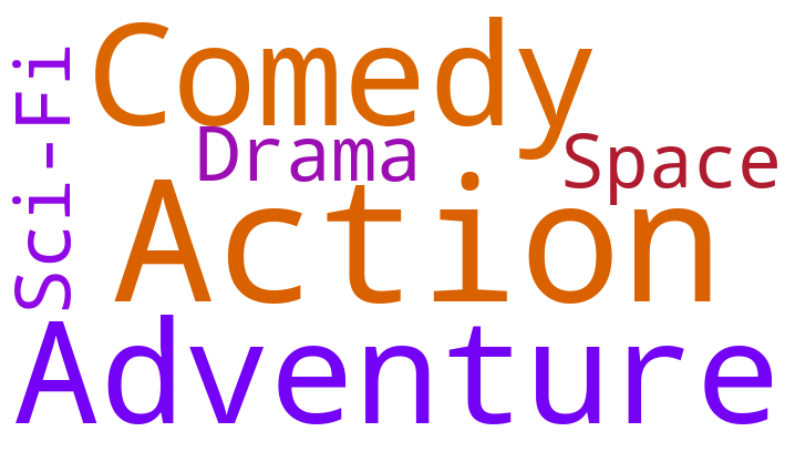

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [ ]:
getFavGenre(x, plot=True)

### Extracting User Preferences

In [ ]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    # 🎯 Step 1: Get all animes rated by the user
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    # 🧠 Step 2: Calculate the 75th percentile of the user's ratings
    # (i.e., we consider only the top 25% of their ratings as preferences)
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    # 🔍 Step 3: Filter animes that the user rated above or equal to the 75th percentile
    animes_watched_by_user = animes_watched_by_user[
        animes_watched_by_user.rating >= user_rating_percentile
    ]

    # 📋 Step 4: Get anime_ids sorted by rating (descending)
    top_animes_user = animes_watched_by_user.sort_values(
        by="rating", ascending=False
    ).anime_id.values

    # 📄 Step 5: Get rows from master anime DataFrame (df) for those top anime_ids
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]

    # 🧼 Step 6: Keep only name and genres for display
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    # ☁️ Optional Step 7: Plot genre preferences as word cloud
    if plot:
        getFavGenre(anime_df_rows, plot)

    # ✅ Return top-rated anime data (name + genres) for the user
    return anime_df_rows


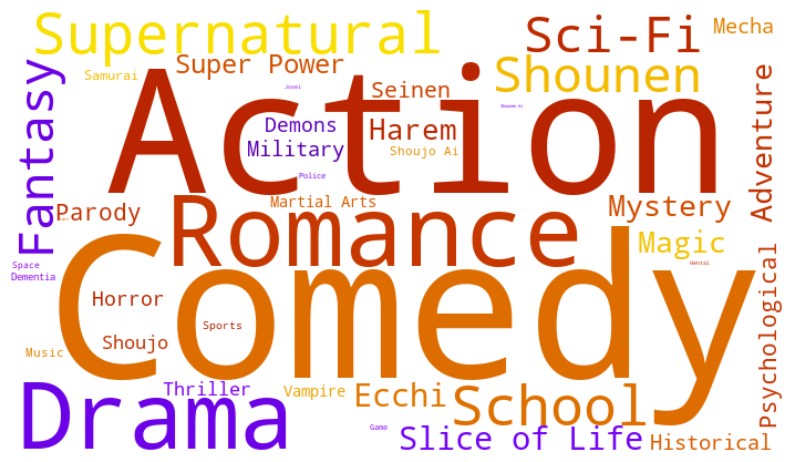

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
5683,Steins;Gate,"Thriller, Sci-Fi"
14963,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Sho..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
...,...,...
4003,First Squad:The Moment of Truth,"Action, Historical, Military, Super Power, Sup..."
512,NaN,"Drama, Romance, School, Supernatural"
745,NaN,"Comedy, Ecchi, Magic, Romance, School"
623,Koi Koi Seven,"Comedy, Harem, Romance"


In [94]:
get_user_preferences(8408, rating_df, df, plot=True)

### Generate Anime Recommendations for a User Based on Similar Users

This function uses collaborative filtering (user-based) to recommend new animes to a target user. It works by:
- Fetching top-rated animes from similar users.
- Removing those animes the target user already watched.
- Counting how frequently each unseen anime appears in similar users' top picks.
- Recommending the most commonly loved animes with their genres and synopsis.


In [ ]:
def get_user_recommendations(
    similar_users, user_pref, df, synopsis_df, rating_df, n=10
):
    recommended_animes = []  # Final list of recommended anime dictionaries
    anime_list = []  # Temp list to collect anime names from similar users

    # 🔁 Loop through each similar user's ID
    for user_id in similar_users.similar_users.values:
        # 🔍 Get top-rated animes for this user
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        # ❌ Remove animes already watched by the main user
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        # ✅ If this user has some unique preferences, add them
        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        # 🧱 Flatten the list and count frequency of each anime
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(
            pd.Series(anime_list.values.ravel()).value_counts()
        ).head(n)  # Keep top-N most frequent animes

        # 🔄 For each popular unseen anime, enrich with metadata
        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)

                recommended_animes.append(
                    {
                        "n": n_user_pref,
                        "anime_name": anime_name,
                        "Genres": genre,
                        "Synopsis": synopsis,
                    }
                )

    return pd.DataFrame(recommended_animes).head(n)  # Final recommendations

##### Find Similar Users:

In [ ]:
similar_users = find_similar_users(
    int(8408), user_weights, user2user_encoded, user2user_decoded
)

+ Finds users most similar to user 8408 based on user embedding vectors.

##### Get User Preferences:

In [96]:
user_pref = get_user_preferences(8408, rating_df, df, plot=False)

+ Fetches top-rated animes (above 75th percentile) by user 8408.

##### Get Recommendations:

In [99]:
get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=10)

,n,anime_name,Genres,Synopsis
0,11,Amagami SS,"Slice of Life, Comedy, Romance, School","Two years ago, Junichi Tachibana had a date on..."
1,10,Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",Simon and Kamina were born and raised in a dee...
2,8,Good Luck! Ninomiya-kun,"Harem, Comedy, Ecchi, Fantasy","Shungo Ninomiya is just an ordinary, run-of-th..."
3,7,Genshiken 2,"Comedy, Parody, Slice of Life",The Society for the Study of Modern Visual Cul...
4,7,Hatsukoi Limited,"Comedy, Romance, School, Shounen",series relating the intertwined stories about ...
5,7,Ladies versus Butlers!,"Harem, Comedy, Romance, Ecchi, School",Hino Akiharu lost his parents when he was smal...
6,7,Yamada's First Time:B Gata H Kei,"Comedy, Ecchi, Romance, School, Seinen","ost people, including the girl herself, would ..."
7,7,Fate/stay night,"Action, Supernatural, Magic, Romance, Fantasy","fter a mysterious inferno kills his family, Sh..."
8,7,Bakuman.,"Comedy, Drama, Romance, Shounen","Onto their third serialization, manga duo Mori..."
9,7,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","aku Ichijou, a first-year student at Bonyari H..."


+ Recommends 10 anime most frequently liked by similar users, but not watched by user 8408.

##### Visual Display

In [ ]:
df_recommendations = get_user_recommendations(
    similar_users, user_pref, df, synopsis_df, rating_df, n=10
)

for i, row in df_recommendations.iterrows():
    print(f"\n🎬 **{row['anime_name']}**")
    print(f"📚 Genre: {row['Genres']}")
    print(f"📝 Synopsis: {row['Synopsis'][:300]}...")


🎬 **Amagami SS**
📚 Genre: Slice of Life, Comedy, Romance, School
📝 Synopsis: Two years ago, Junichi Tachibana had a date on Christmas Eve but was stood up instead. Since then, he has had a hard time showing others his true feelings in fear of being rejected again. However, as luck would have it, Junichi may have a second chance at love when he meets several girls whom he bec...

🎬 **Gurren Lagann**
📚 Genre: Action, Adventure, Comedy, Mecha, Sci-Fi
📝 Synopsis: Simon and Kamina were born and raised in a deep, underground village, hidden from the fabled surface. Kamina is a free-spirited loose cannon bent on making a name for himself, while Simon is a timid young boy with no real aspirations. One day while excavating the earth, Simon stumbles upon a mysteri...

🎬 **Good Luck! Ninomiya-kun**
📚 Genre: Harem, Comedy, Ecchi, Fantasy
📝 Synopsis: Shungo Ninomiya is just an ordinary, run-of-the-mill high school student who lives at home with his older sister Ryoko—at least when she's not away d

## HYBRID RECOMMENDER SYSTEM

- This function combines:

   + 👥 User-based collaborative filtering
   
   + 📺 Content-based recommendation

##### Output Behavior
- If:
     + user_weight = 1.0, you'll only get user-based recs

     + content_weight = 1.0, you'll only get content-based recs
     
     + Both = 0.5 → hybrid of both types

In [ ]:
def hybrid_recommendation(
    user_id, user_weight=0.5, content_weight=0.5, top_n=10, verbose=True
):
    """
    Hybrid Recommendation System: Combines User-Based and Content-Based filtering
    using weighted scoring.

    Parameters:
    - user_id: ID of the user for whom recommendations are generated
    - user_weight: weight assigned to user-based recommendations
    - content_weight: weight assigned to content-based recommendations
    - top_n: number of top recommendations to return
    - verbose: if True, prints intermediate outputs

    Returns:
    - DataFrame with top N hybrid recommended anime along with score breakdown
    """

    # --- USER-BASED RECOMMENDATION ---

    # Step 1: Find users similar to the target user based on embedding similarity
    similar_users = find_similar_users(
        user_id, user_weights, user2user_encoded, user2user_decoded
    )

    # Step 2: Get the user's top-preference genres/anime
    user_pref = get_user_preferences(user_id, rating_df, df)

    # Step 3: Recommend anime that similar users liked, excluding already seen ones
    user_recommended_animes = get_user_recommendations(
        similar_users, user_pref, df, synopsis_df, rating_df
    )

    # Convert user-based recommended anime to list
    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()

    if verbose:
        print(f"\n👥 User-based Recommendations ({len(user_recommended_anime_list)}):")
        print(user_recommended_anime_list)

    # --- CONTENT-BASED RECOMMENDATION ---

    # Step 4: For each anime in the user recommendation list, find similar animes
    content_recommended_animes = []
    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(
            anime,
            anime_weights,
            anime2anime_encoded,
            anime2anime_decoded,
            df,
            synopsis_df,
        )

        # If similar animes are found, extend the content recommendation list
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())

    if verbose:
        print(
            f"\n📺 Content-based Recommendations ({len(content_recommended_animes)}):"
        )
        print(content_recommended_animes[:top_n])

    # --- COMBINE SCORES FROM BOTH SOURCES ---

    combined_scores = {}  # final score dictionary
    source_breakdown = {}  # stores contribution from user/content for each anime

    # Step 5: Add scores from user-based recommendations
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight
        source_breakdown.setdefault(anime, {"user": 0, "content": 0})
        source_breakdown[anime]["user"] += user_weight

    # Step 6: Add scores from content-based recommendations
    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight
        source_breakdown.setdefault(anime, {"user": 0, "content": 0})
        source_breakdown[anime]["content"] += content_weight

    # --- SORT AND FORMAT FINAL OUTPUT ---

    # Step 7: Sort all animes by final combined score
    sorted_items = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[
        :top_n
    ]

    # Step 8: Build final recommendation DataFrame with scores and sources
    final_recs = []
    for anime, score in sorted_items:
        breakdown = source_breakdown[anime]
        try:
            frame = getAnimeFrame(anime, df)
            genre = frame.Genres.values[0]
        except:
            genre = "Unknown"

        final_recs.append(
            {
                "anime_name": anime,
                "genre": genre,
                "hybrid_score": round(score, 2),
                "user_score": round(breakdown["user"], 2),
                "content_score": round(breakdown["content"], 2),
            }
        )
    result_df = pd.DataFrame(final_recs)

    # Step 9: Optionally print top recommendations
    if verbose:
        print(f"\n🔝 Top {top_n} Hybrid Recommendations:\n")
        print(result_df.to_string(index=False))

    # Step 10: Return final DataFrame
    return result_df

In [133]:
result_df = hybrid_recommendation(user_id=8408, user_weight=0.5, content_weight=0.5)


👥 User-based Recommendations (10):
['Amagami SS', 'Gurren Lagann', 'Good Luck! Ninomiya-kun', 'Genshiken 2', 'Hatsukoi Limited', 'Ladies versus Butlers!', "Yamada's First Time:B Gata H Kei", 'Fate/stay night', 'Bakuman.', 'Nisekoi:False Love']

📺 Content-based Recommendations (87):
['Amagami SS+ plus', 'Aria the Scarlet Ammo', 'The World God Only Knows', "Heaven's Memo Pad", 'The Ambition of Oda Nobuna', 'Infinite Stratos', 'Koe de Oshigoto!', 'The World God Only Knows II', 'Campione!', 'Chrome Shelled Regios']

🔝 Top 10 Hybrid Recommendations:

                            anime_name                                                            genre  hybrid_score  user_score  content_score
                Ladies versus Butlers!                            Harem, Comedy, Romance, Ecchi, School           1.5         0.5            1.0
                              Bakuman.                                  Comedy, Drama, Romance, Shounen           1.5         0.5            1.0
            

#### `hybrid_score` (Final Score)

The **total weighted score** for an anime, calculated by combining:

- 👥 The **user-based score**
- 📺 The **content-based score**

#####  Formula:
```python
hybrid_score = user_score + content_score


####  `user_score`
 + Score contribution based on similar users’ preferences.
 + If similar users liked an anime (and the target user hasn't seen it), it earns a user_weight score.

##### Example:
```python
user_score += 0.5  # if user_weight = 0.5


####  `content_score`
 + Score contribution based on similarity to animes the user liked — using features like genre, synopsis, and embeddings
##### Example:
```python
content_score += 0.5  # if content_weight = 0.5

### Top Recommendations Explanations:

| Rank | Anime Name                                                                                  | Source Strength           | Notes                                                                                   |
| ---- | ------------------------------------------------------------------------------------------- | ------------------------- | --------------------------------------------------------------------------------------- |
| 1    | **Ladies versus Butlers!**                                                                  | 0.5 + 1.0 = **1.5** | Similar users liked it **and** it's similar to content user likes.                      |
| 2    | **Bakuman.**                                                                                |  0.5 + 1.0 = **1.5** | Also strongly supported by both user and content signals.                               |
| 3    | **Good Luck! Ninomiya-kun**                                                                 | 0.5 + 0.5 = **1.0** | Mid-strength on both sides.                                                             |
| 4    | **Nisekoi\:False Love**                                                                     | 0.5 + 0.5 = **1.0** | Balanced but not dominant in either source.                                             |
| 5–10 | **Content-only hits** like:<br>Amagami SS+ plus, Infinite Stratos, Code Geass R1 & R2, etc. | 0.0 + 1.0 = **1.0** | These were **not liked by similar users** but are **very similar to content you like**. |
